## Utilizing Expert Knowledge

Feature engineering is often an important place to use expert knowledge for a particular application. While the purpose of machine learning in many cases is to avoid having to create a set of expert-designed rules, that doesn’t mean that prior knowledge of the application or domain should be discarded. Often, domain experts can help in identifying useful features that are much more informative than the initial representation of the data. 

Imagine you work for a travel agency and want to predict flight prices. Let’s say you have a record of prices together with dates, airlines, start locations, and destinations. A machine learning model might be able to build a decent model from that. Some important factors in flight prices, however, cannot be learned. For example, flights are usually more expensive during peak vacation months and around holidays. While the dates of some holidays (like Christmas) are fixed, and their effect can therefore be learned from the date, others might depend on the phases of the moon (like Hanukkah and Easter) or be set by authorities (like school holidays). These events cannot be learned from the data if each flight is only recorded using the (Gregorian) date. However, it is easy to add a feature that encodes whether a flight was on, preceding, or following a public or school holiday. 

In this way, prior knowledge about the nature of the task can be encoded in the features to aid a machine learning algorithm. Adding a feature does not force a machine learning algorithm to use it, and even if the holiday information turns out to be noninformative for flight prices, augmenting the data with this information doesn’t hurt.

We’ll now look at one particular case of using expert knowledge—though in this case it might be more rightfully called “common sense.” The task is predicting bicycle rentals in front of Andreas’s house.

In New York, Citi Bike operates a network of bicycle rental stations with a subscription system. The stations are all over the city and provide a convenient way to get around. Bike rental data is made public in an anonymized form and has been analyzed in various ways. The task we want to solve is to predict for a given time and day how many people will rent a bike in front of Andreas’s house—so he knows if any bikes will be left for him.

We first load the data for August 2015 for this particular station as a pandas *DataFrame*. We resample the data into three-hour intervals to obtain the main trends for each day:

In [2]:
# Standard imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy as sp
import sklearn
from IPython.display import display
import mglearn

# Don't display deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [3]:
citibike = mglearn.datasets.load_citibike()

In [4]:
print("Citi Bike data:\n{}".format(citibike.head()))

Citi Bike data:
starttime
2015-08-01 00:00:00     3
2015-08-01 03:00:00     0
2015-08-01 06:00:00     9
2015-08-01 09:00:00    41
2015-08-01 12:00:00    39
Freq: 3H, Name: one, dtype: int64


The following example shows a visualization of the rental frequencies for the whole month:

Text(0, 0.5, 'Rentals')

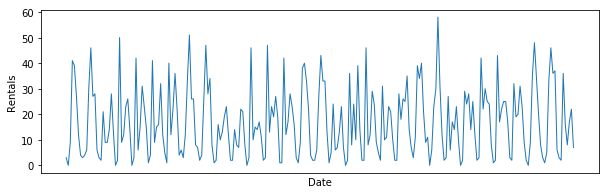

In [5]:
plt.figure(figsize=(10, 3))

xticks = pd.date_range(start=citibike.index.min(), end=citibike.index.max(), freq='D')
plt.xticks(xticks.astype("int"), xticks.strftime("%a %m-%d"), rotation=90, ha="left")

plt.plot(citibike, linewidth=1)
plt.xlabel("Date")
plt.ylabel("Rentals")

Looking at the data, we can clearly distinguish day and night for each 24-hour interval. The patterns for weekdays and weekends also seem to be quite different. When evaluating a prediction task on a time series like this, we usually want to *learn from the past* and *predict for the future*. 

This means when doing a split into a training and a test set, we want to use all the data up to a certain date as the training set and all the data past that date as the test set. This is how we would usually use time series prediction: given everything that we know about rentals in the past, what do we think will happen tomorrow? We will use the first 184 data points, corresponding to the first 23 days, as our training set, and the remaining 64 data points, corresponding to the remaining 8 days, as our test set.

The only feature that we are using in our prediction task is the date and time when a particular number of rentals occurred. So, the input feature is the date and time—say, 2015-08-01 00:00:00—and the output is the number of rentals in the following three hours (three in this case, according to our *DataFrame*).